<a href="https://colab.research.google.com/github/TomographicImaging/gVXR-Tutorials/blob/main/notebooks/segmentation-to-CT_scan-simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
#
#  Copyright 2025 United Kingdom Research and Innovation
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Franck Vidal (UKRI-STFC)

![gVXR](https://github.com/TomographicImaging/gVXR-Tutorials/blob/main/img/Logo-transparent-small.png?raw=1)

# From image segmentation to CT simulation

This notebook shows how to load a segmented image and you it to create a multi-part sample. 
It relies on functions built in gVXR, i.e. no third-party software is required. 
The functionality is multi-threaded to boost performances. 
It is then used to simulate a CT scan acquisition with gVXR and recontruct it with CIL.

![Segmented data](../data/labels.png)

<div class="alert alert-block alert-warning">
    <b>Note:</b> Make sure the Python packages are already installed. See <a href="../README.md">README.md</a> in the root directory of the repository. If you are running this notebook from Google Colab, please run the cell below to install the package with `!pip install gvxr`
</div>

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !apt-get install libnvidia-gl-575
    !pip install -q condacolab
    import condacolab
    condacolab.install()

    !conda install -y -c conda-forge -c https://software.repos.intel.com/python/conda -c ccpi cil=24.3.0 ipp=2021.12 tigre

    !pip install gvxr

In [3]:
import os # Create the output directory if necessary
import numpy as np # Who does not use Numpy?

from tifffile import  imread
import matplotlib.pyplot as plt # Plotting

from tqdm.notebook import tqdm

#  CT simulation
from gvxrPython3 import gvxr
from gvxrPython3.gVXRDataReader import *

# CT reconstruction
from cil.recon import FDK # For CBCT
from cil.recon import FBP # For parallel beam geometry

from cil.io import TIFFWriter

from cil.processors import TransmissionAbsorptionConverter
from cil.utilities.display import show_geometry, show2D

## Getting the data ready

Where to save the data.

In [4]:
output_path = "../notebooks/output_data/segmentation-to-CT_scan-simulation"
if not os.path.exists(output_path):
    os.makedirs(output_path)

## 1. Set the simulation environment

In [5]:
# Create an OpenGL context
print("Create an OpenGL context");
gvxr.createOpenGLContext();

Create an OpenGL context


Tue Jul 22 14:27:53 2025 ---- Create window (ID: -1)
Tue Jul 22 14:27:53 2025 ---- Request an interactive OpenGL context
Tue Jul 22 14:27:53 2025 ---- Initialise GLFW
Tue Jul 22 14:27:53 2025 ---- Create an OpenGL window with a 4.3 context.
Tue Jul 22 14:27:53 2025 ---- Make the window's context current
Tue Jul 22 14:27:53 2025 ---- Initialise GLEW
Tue Jul 22 14:27:53 2025 ---- OpenGL vendor: NVIDIA Corporation
Tue Jul 22 14:27:53 2025 ---- OpenGL renderer: NVIDIA GeForce RTX 4060 Ti/PCIe/SSE2
Tue Jul 22 14:27:53 2025 ---- OpenGL version: 4.3.0 NVIDIA 570.153.02
Tue Jul 22 14:27:53 2025 ---- Use OpenGL 4.5.
Tue Jul 22 14:27:53 2025 ---- Use OpenGL Compute Shader.
Tue Jul 22 14:27:53 2025 ---- Initialise the X-ray renderer if needed and if possible


In [6]:
rotation_centre = [0, 0, 0]

In [7]:
# Create a source
print("Set up the beam")
gvxr.setSourcePosition(-40.0,  0.0, 0.0, "cm")
gvxr.usePointSource()
#  For a parallel source, use gvxr.useParallelBeam()

Set up the beam


In [8]:
# Set its spectrum, here a monochromatic beam
# 1000 photons of 80 keV (i.e. 0.08 MeV) per ray
gvxr.addEnergyBinToSpectrumPerPixelAtSDD(33, "keV", 97)
gvxr.addEnergyBinToSpectrumPerPixelAtSDD(66, "keV", 2)
gvxr.addEnergyBinToSpectrumPerPixelAtSDD(99, "keV", 1)

In [9]:
# Set up the detector
print("Set up the detector")
gvxr.setDetectorPosition(10.0, 0.0, 0.0, "cm")
gvxr.setDetectorUpVector(0, 0, 1)
gvxr.setDetectorNumberOfPixels(1000, 3)
gvxr.setDetectorPixelSize(1.0, 1.0, "um")
gvxr.setScintillator("GGG", 170, "um")

Set up the detector


Tue Jul 22 14:27:54 2025 ---- Initialise the renderer


## 2. Create the sample from a segmented image

Read the image

In [10]:
labels = imread("../data/labels.tif")
voxel_size = [1.5, 1.5, 1.5]
unit = "um"

Display the image

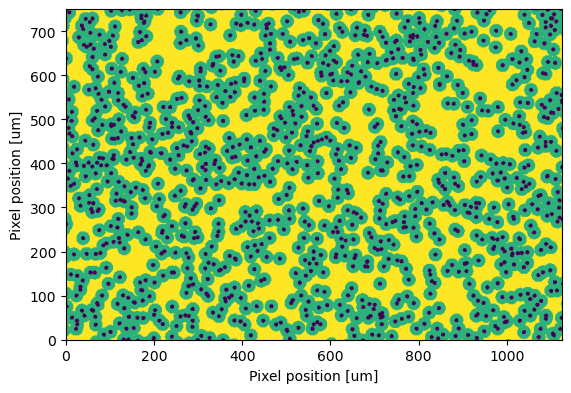

In [11]:
plt.figure()
plt.imshow(labels,
    origin='upper',
    extent=[0.0, voxel_size[0] * labels.shape[1],
        0.0, voxel_size[1] * labels.shape[0]]
)
plt.xlabel("Pixel position [" + unit + "]")
plt.ylabel("Pixel position [" + unit + "]")
plt.show()

Make sure it is a 3D image

In [12]:
if len(labels.shape) == 2:
    labels.shape = [1, *labels.shape]

Associate the labels with actual materials

In [13]:
material_composition = {
    112: {
        'material type': 'element', 
        'material': 'C', 
        'density': 2.26
    }
    ,

    170: {
        'material type': 'compound', 
        'material': 'SiC', 
        'density': 3.21
    },

    202: {
        'material type': 'mixture', 
        'material': 'Ti90Al6V4', 
        'density': 4.43
    }
}

Process the segmentation to create iso surfaces

In [14]:
for label in tqdm(np.unique(labels)):

    if label in material_composition.keys():
        selected_material = material_composition[label]
        mesh_label = material_composition[label]['material']

        print("Process", mesh_label)

        # Select the structure
        binary_image = (labels == label).astype(np.uint8)

        # Apply the Marching cubes
        gvxr.makeIsoSurface(mesh_label,
            binary_image,
            1,
            *rotation_centre,
            *voxel_size,
            "um"
        )

        # Save the mesh as an STL file
        gvxr.saveSTLfile(mesh_label, os.path.join(output_path, mesh_label+".stl"))

        # Set the material
        if selected_material['material type'].upper() == 'ELEMENT':
            print("\tUse element", mesh_label)
            gvxr.setElement(mesh_label, mesh_label)

            if "density" in selected_material:
                gvxr.setDensity(mesh_label, selected_material["density"], "g/cm3")

        elif selected_material['material type'].upper() == 'COMPOUND':
            print("\tUse compound", mesh_label)
            gvxr.setCompound(mesh_label, mesh_label)
            gvxr.setDensity(mesh_label, selected_material["density"], "g/cm3")
        
        elif selected_material['material type'].upper() == 'MIXTURE':
            print("\tUse mixture", mesh_label)
            gvxr.setMixture(mesh_label, mesh_label)
            gvxr.setDensity(mesh_label, selected_material["density"], "g/cm3")
        
        else:
            raise IOError("Invalid material type")

        # Add the material
        gvxr.addPolygonMeshAsInnerSurface(mesh_label)
    else:
        print(label, "is not in", material_composition)


  0%|          | 0/3 [00:00<?, ?it/s]

Process C
	Use element C
Process SiC
	Use compound SiC
Process Ti90Al6V4
	Use mixture Ti90Al6V4


Simulate the CT scan

In [15]:
rotation_centre = [0, 0, 0]
number_of_projections = 3000

gvxr.computeCTAcquisition(
    os.path.join(output_path, "projections"), # The path where the X-ray projections will be saved
    "", # The path where the screenshots will be saved
    number_of_projections, # The total number of projections to simulate
    0, # The rotation angle corresponding to the first projection
    False, # A boolean flag to include or exclude the last angle
    360, # The rotation angle corresponding to the first projection
    50, # The number of white images used to perform the flat-field correction
    *rotation_centre, # The location of the rotation centre
    "mm", # The corresponding unit of length
    0, 0, 1 # The rotation axis
)  

Read the simulated data with CIL

In [16]:
reader = gVXRDataReader(gvxr.getProjectionOutputPathCT(),
    gvxr.getAngleSetCT(),
    rotation_centre)

data = reader.read()

[1000    3]
[0.001, 0.001]


In [17]:
print("data.geometry", data.geometry)

data.geometry 3D Cone-beam tomography
System configuration:
	Source position: [400.,  -0.,  -0.]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [-100.,   -0.,   -0.]
	Detector direction x: [ 0., -1.,  0.]
	Detector direction y: [-0., -0., -1.]
Panel configuration:
	Number of pixels: [1000    3]
	Pixel size: [0.001 0.001]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 3000
	Angles 0-9 in degrees: [0.        , 0.12      , 0.24      , 0.35999998, 0.48      , 0.59999996,
 0.71999997, 0.84      , 0.96      , 1.0799999 ]
	Angles 2990-2999 in degrees: [358.8    , 358.91998, 359.03998, 359.16   , 359.28   , 359.4    ,
 359.52   , 359.63998, 359.75998, 359.88   ]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance


Apply the minus log transformation (use use white_level=1.0 as the flat-field correction is already applied)

In [18]:
data_corr = TransmissionAbsorptionConverter(white_level=1.0)(data)

In [19]:
data_corr.reorder(order='tigre')

We only want to reconstruct the slice in the middle of the volume

In [20]:
ig = data_corr.geometry.get_ImageGeometry();

ig.voxel_num_z = 1
print("Image geometry", ig)

Image geometry Number of channels: 1
channel_spacing: 1.0
voxel_num : x1000,y1000,z1
voxel_size : x0.0008,y0.0008,z0.0008
center : x0,y0,z0



In [21]:
# Perform the reconstruction with CIL
FDK_reconstruction = FDK(data_corr, ig).run()

FDK recon

Input Data:
	angle: 3000
	vertical: 3
	horizontal: 1000

Reconstruction Volume:
	horizontal_y: 1000
	horizontal_x: 1000

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



Apply a circular mask as we simulated a region of interest scan

In [22]:
FDK_reconstruction.apply_circular_mask()

Save the reconstructed CT images

In [23]:
writer = TIFFWriter(data=FDK_reconstruction, file_name=os.path.join(output_path, "recons-" + str(number_of_projections), "slice_"), compression="uint16");
writer.write();

Show the CT slice

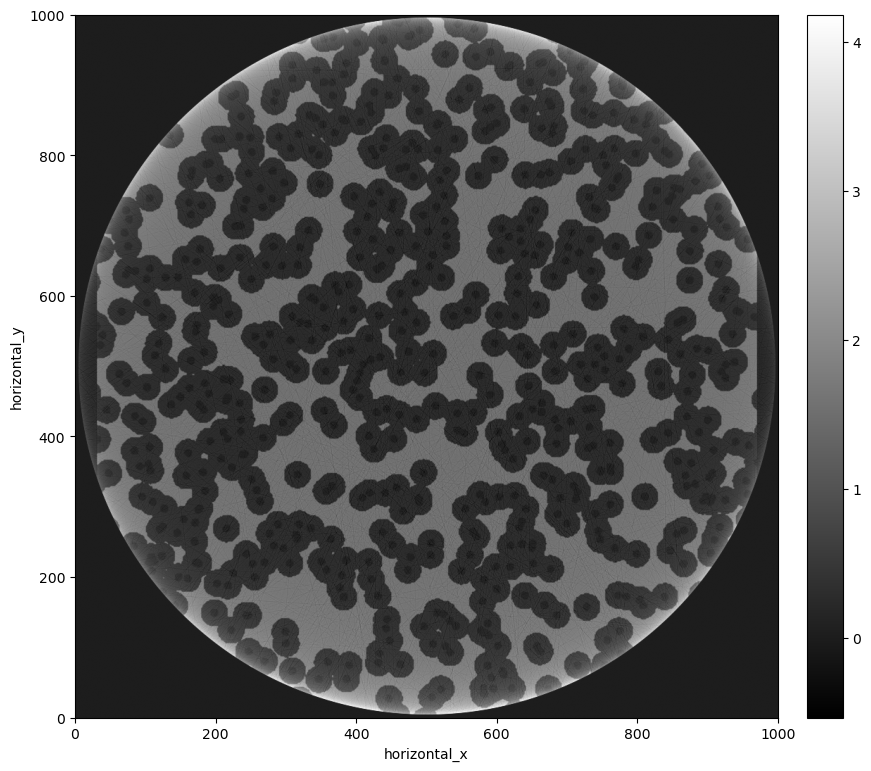

In [24]:
show2D(FDK_reconstruction)

# Cleaning up

Once we have finished, it is good practice to clean up the OpenGL contexts and windows with the following command. Note that due to the object-oriented programming nature of the core API of gVXR, this step is automatic anyway.

In [25]:
gvxr.destroy()

Tue Jul 22 14:28:12 2025 ---- Destroy all the windows
Tue Jul 22 14:28:12 2025 ---- Destroy window 0(0x55d1cea7fc20)
Tue Jul 22 14:28:12 2025 ---- Release all the memory
